In [44]:
using LinearAlgebra
using Flux
using DiffEqFlux
using OrdinaryDiffEq
using GalacticOptim
using Plots

include("src/equations/initial_functions.jl")
include("src/equations/equations.jl")
include("src/utils/graphic_tools.jl")
include("src/utils/generators.jl")
include("src/utils/processing_tools.jl")
include("src/neural_ode/objectives.jl")
include("src/neural_ode/models.jl")

Main.Models

## Analytical solution

Compute the analytical solution u(t, x) and the analytical derivative by time of the solution u(t,x)

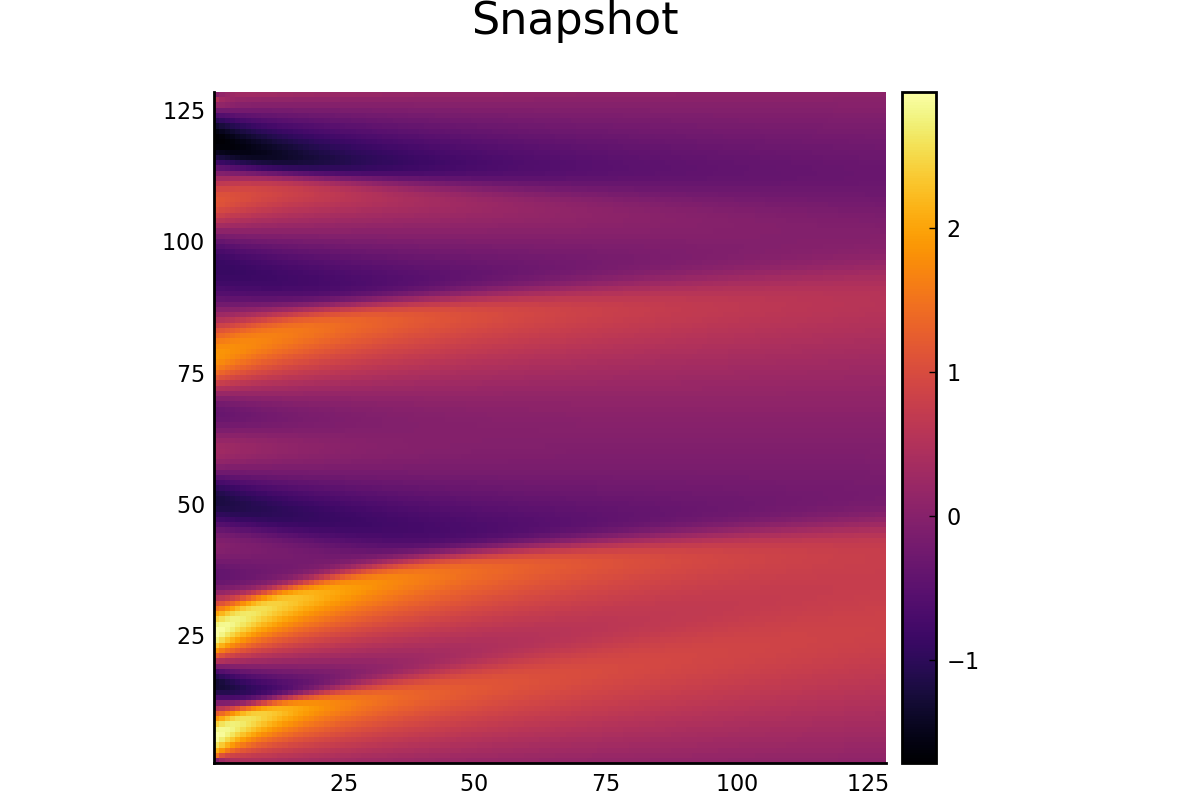

In [129]:
t_max = 0.2;
t_min = 0.;
x_max = 1.;
x_min = 0.;
t_n = 128;
x_n = 128;

nu = 0.01;

dt = round((t_max - t_min) / (t_n - 1), digits=8);
dx = round((x_max - x_min) / (x_n - 1), digits=8);

t = LinRange(t_min, t_max, t_n);
x = LinRange(x_min, x_max, x_n);

u0 = InitialFunctions.high_dim_random_init(t, x);
t, u = Equations.get_burgers_fft(t, dx, x_n, nu, u0[1, :]);
GraphicTools.show_state(u, "Snapshot") # need to reverse u, odesolver switch dimensions

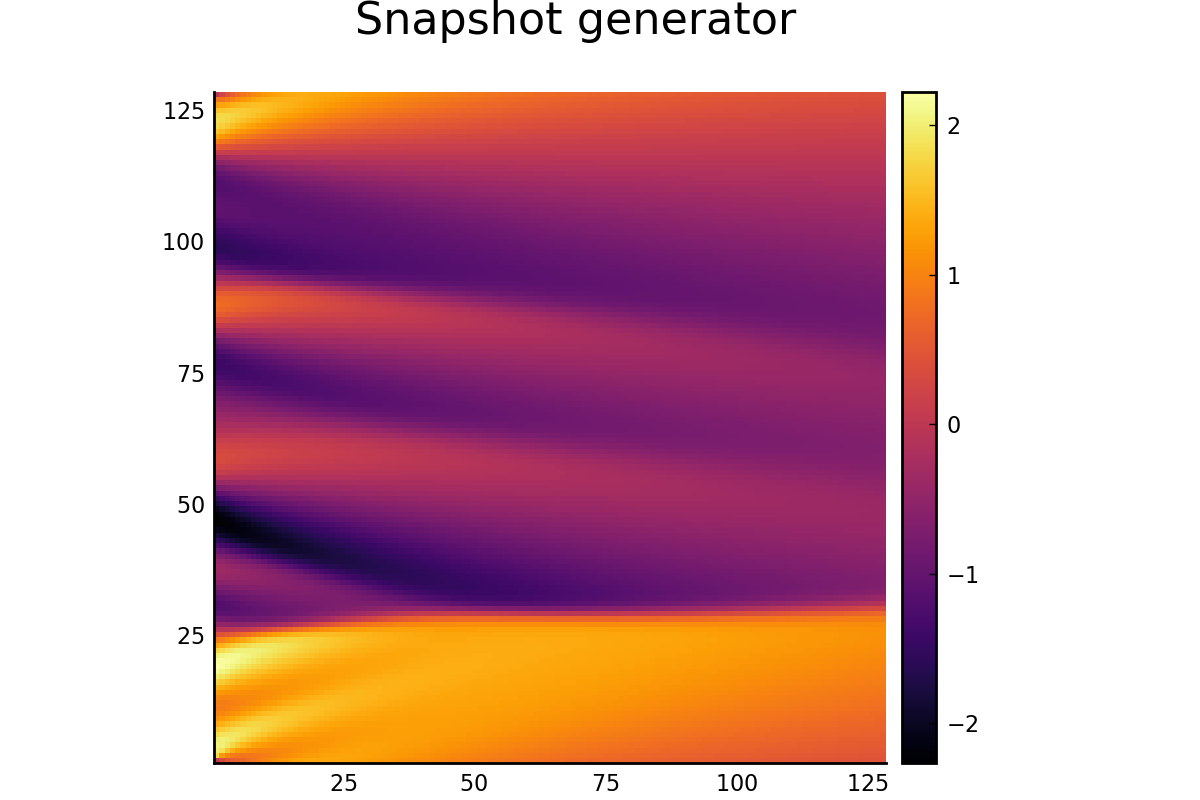

In [56]:
ta, u_a = Generator.burgers_snapshot_generator(t_max, t_min, x_max, x_min, t_n, x_n, nu, 2);
GraphicTools.show_state(u_a, "Snapshot generator")

In [127]:
# dataset = Generator.generate_burgers_training_dataset(t_max, t_min, x_max, x_min, t_n, x_n, nu, 32, 2, 1, false, "./src/dataset/burgers_coarse_training_set.jld2", "training_set");
# high_dataset = Generator.read_dataset("./src/dataset/burgers_high_dim_training_set.jld2")["training_set"];
coarse_dataset = Generator.read_dataset("./src/dataset/burgers_coarse_training_set.jld2")["training_set"];

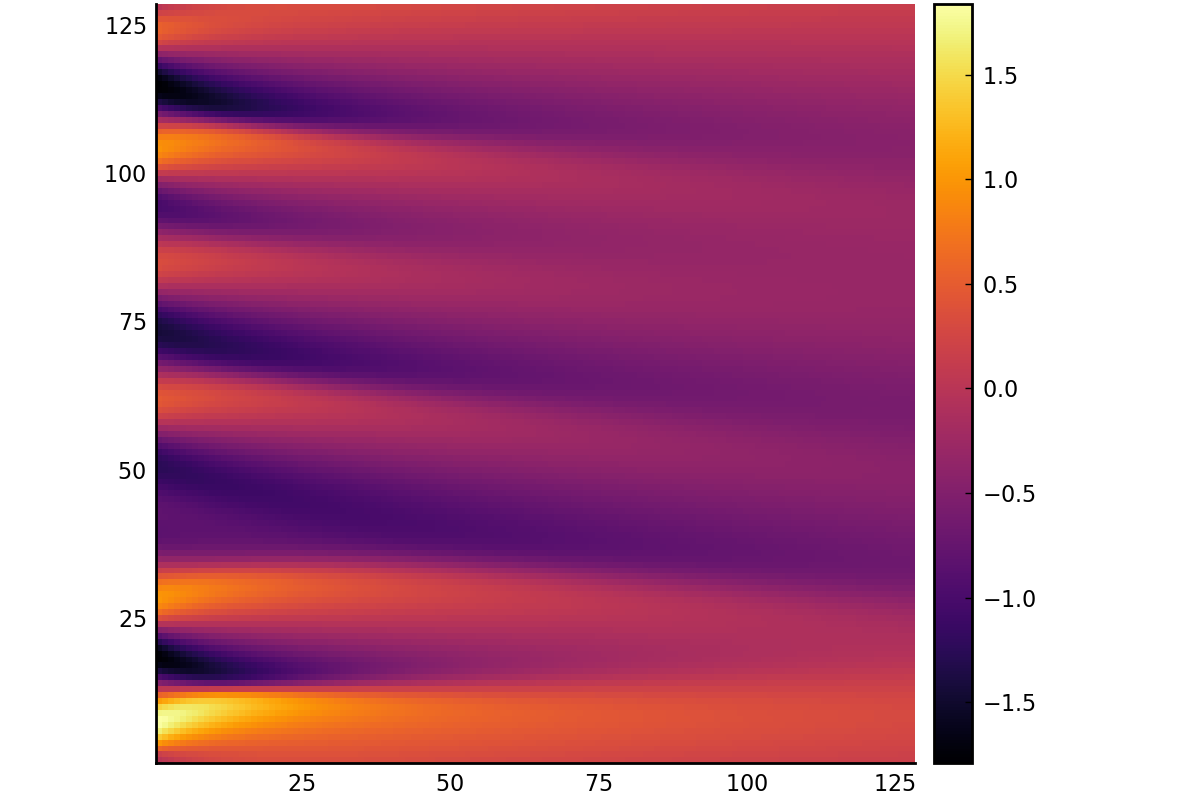

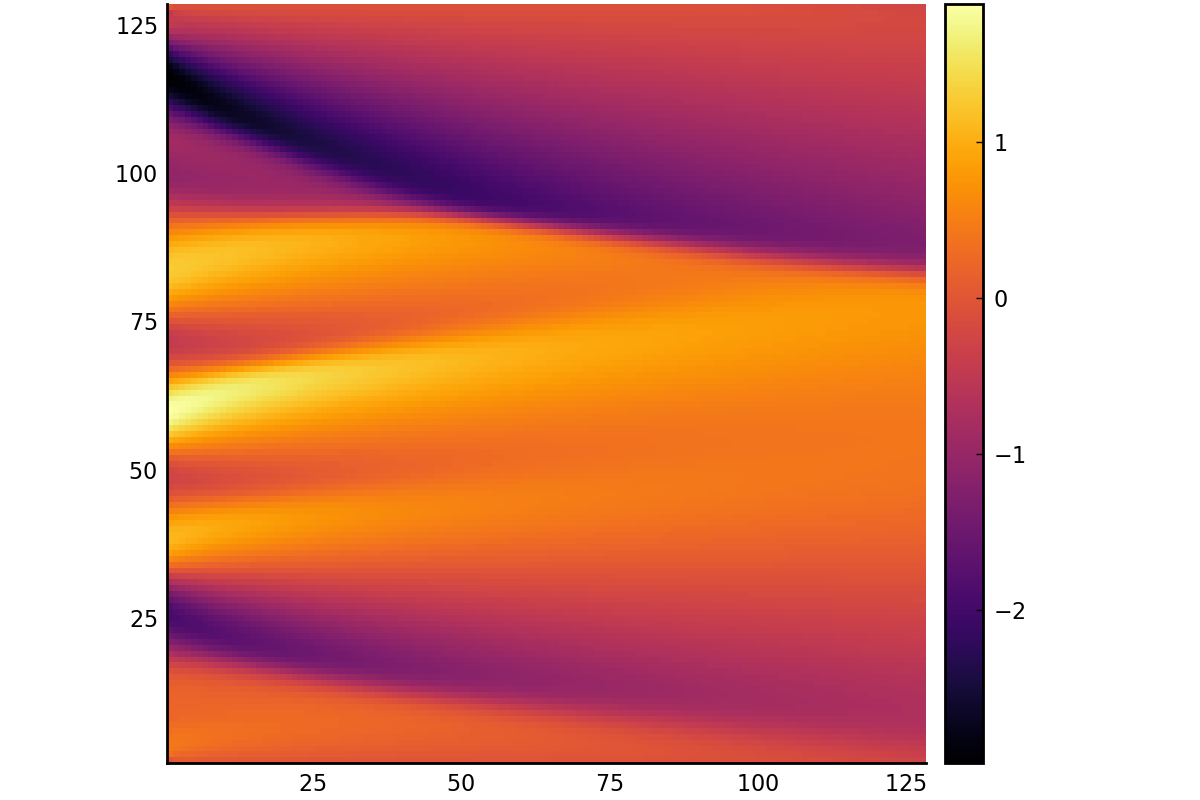

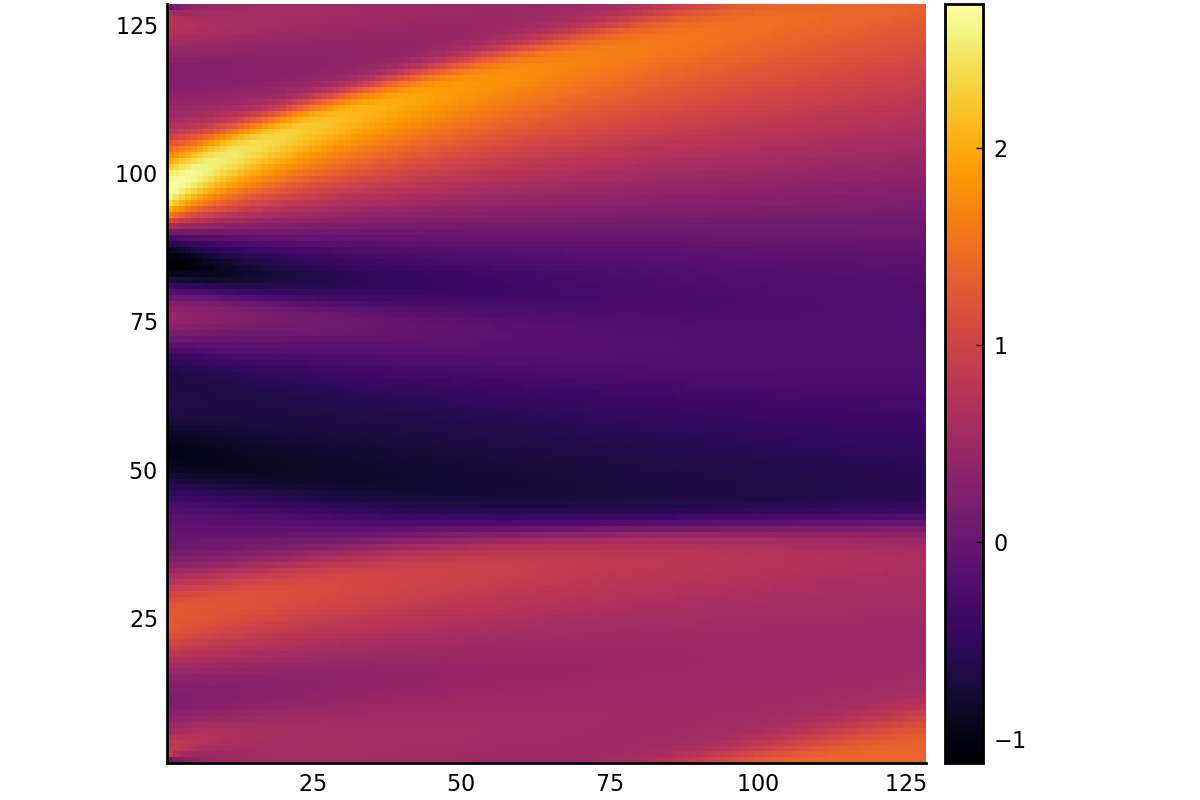

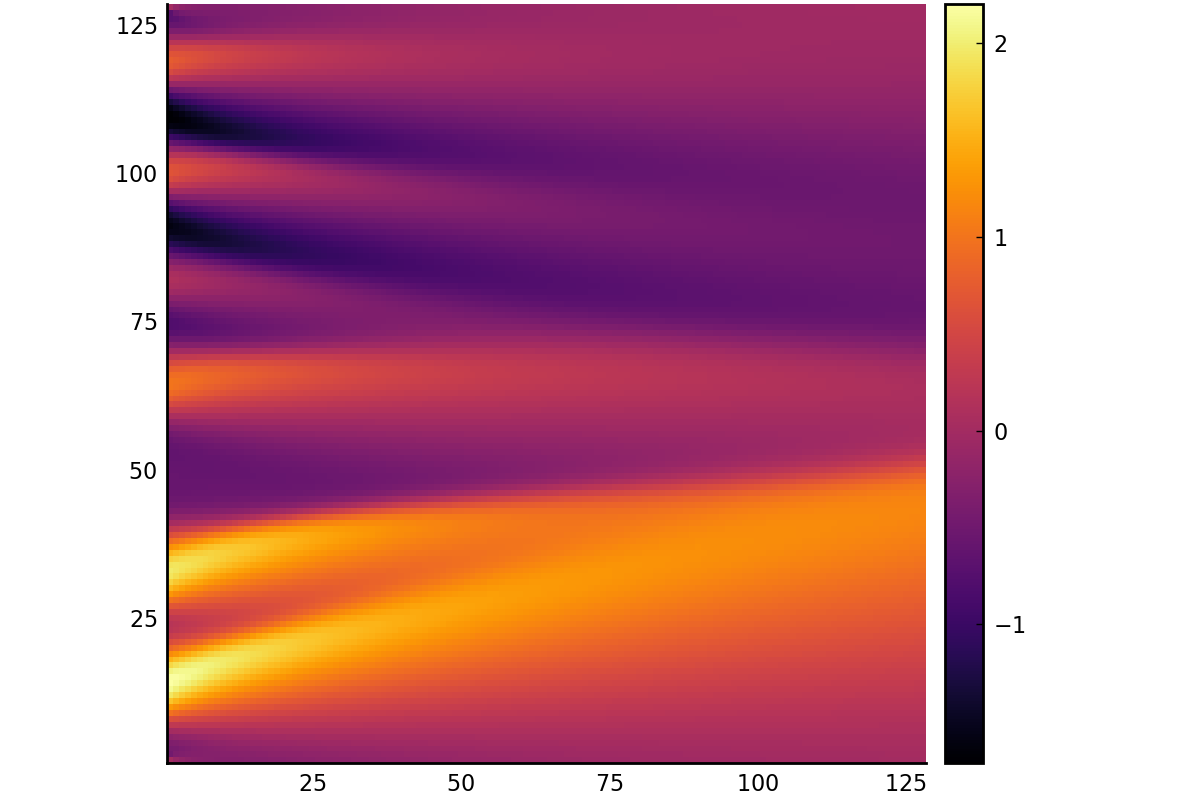

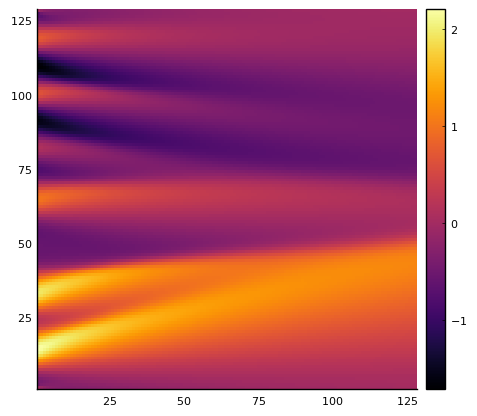

In [128]:
function check_training_dataset(dataset)
    for i in range(1, 4, step=1)
        a, b = dataset[i];
        display(GraphicTools.show_state(b, ""))
    end
end

check_training_dataset(coarse_dataset)

## Training with NeuralODE object

In [60]:
callback(theta, loss, u) = (IJulia.clear_output(true); display(loss); false)

callback (generic function with 2 methods)

In [61]:
function burgers_training(net, epochs, u0, u_true, t)
  optimizer = DiffEqFlux.ADAM(0.01, (0.9, 0.999), 1.0e-8)
  
  tspan = (t[1], t[end])
  neural_ode = NeuralODE(net, tspan, Tsit5(), saveat=t)

  function predict_neural_ode(theta)
    return Array(neural_ode(u0, theta))
  end

  function loss(theta)
    u_pred = predict_neural_ode(theta)
    l = Objectives.mseloss(u_pred, u_true)
    return l, u_pred
  end

  result = DiffEqFlux.sciml_train(loss, neural_ode.p, optimizer; cb = callback, maxiters = epochs);
  return result
end

burgers_training (generic function with 1 method)

In [121]:
t, init_set, true_set = ProcessingTools.process_dataset(coarse_dataset, false);
net = Models.BasicAutoEncoder(x_n);
result = burgers_training(net, 100, init_set, true_set, t);

1.1705527632738326

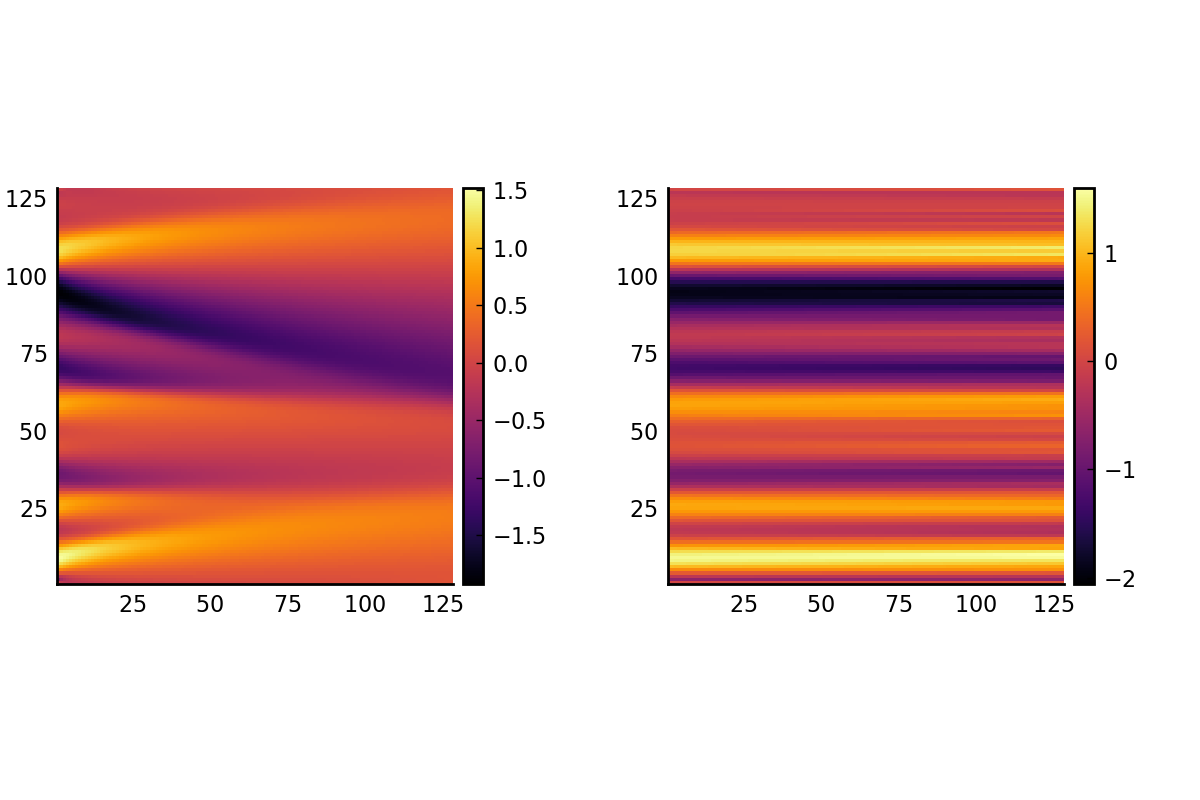

In [130]:
t, u0, u = Generator.get_burgers_batch(t_max, t_min, x_max, x_min, t_n, x_n, nu, 2);
dudt!(u, p, t) = net(u, p)
prob_neuralode = DiffEqFlux.ODEProblem(dudt!, u0, (t[1], t[end]), initial_params(net))
u_pred = solve(prob_neuralode, Tsit5(), saveat = t)

plot(
    GraphicTools.show_state(u, ""),
    GraphicTools.show_state(hcat(u_pred.u...), "");
    layout = (1, 2),
)

### Operator reconstructed

Visualize reconstructed operator and check efficiency to determine solution from unknown sample

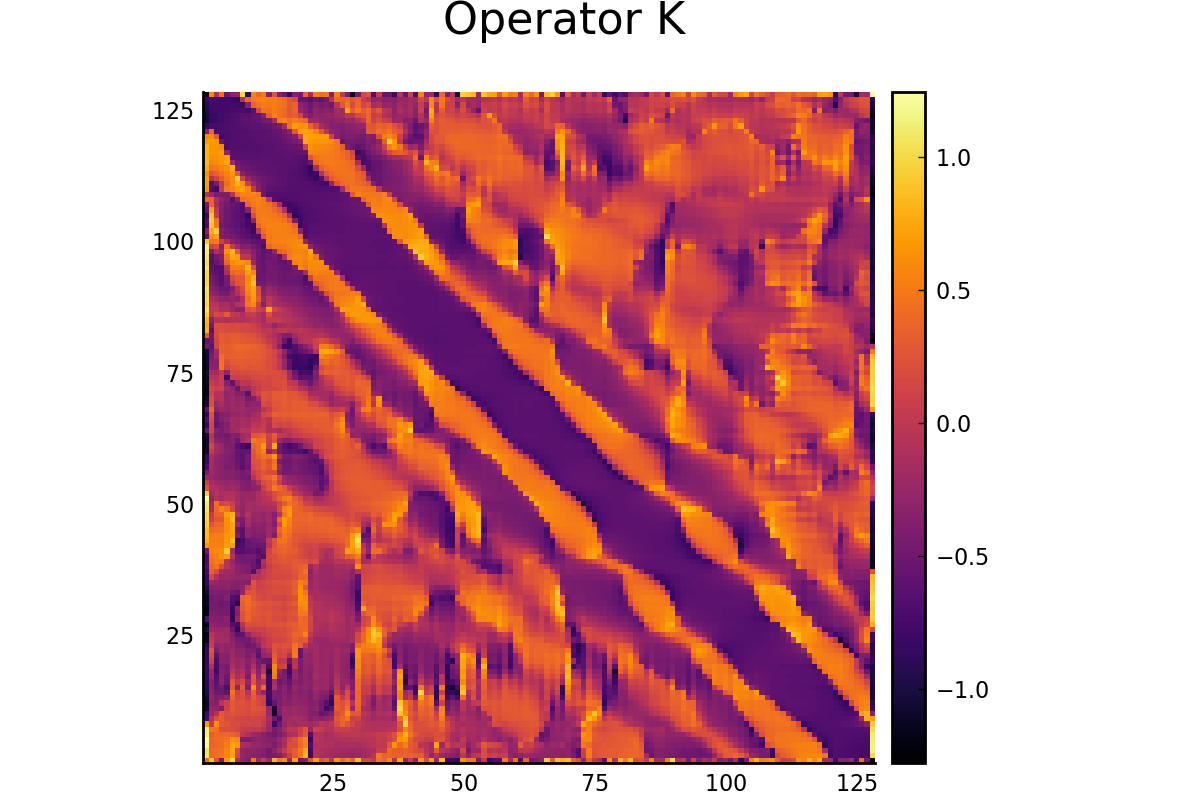

In [76]:
K = reshape(result, (x_n, x_n))
GraphicTools.show_state(reverse(K; dims = 1), "Operator K")

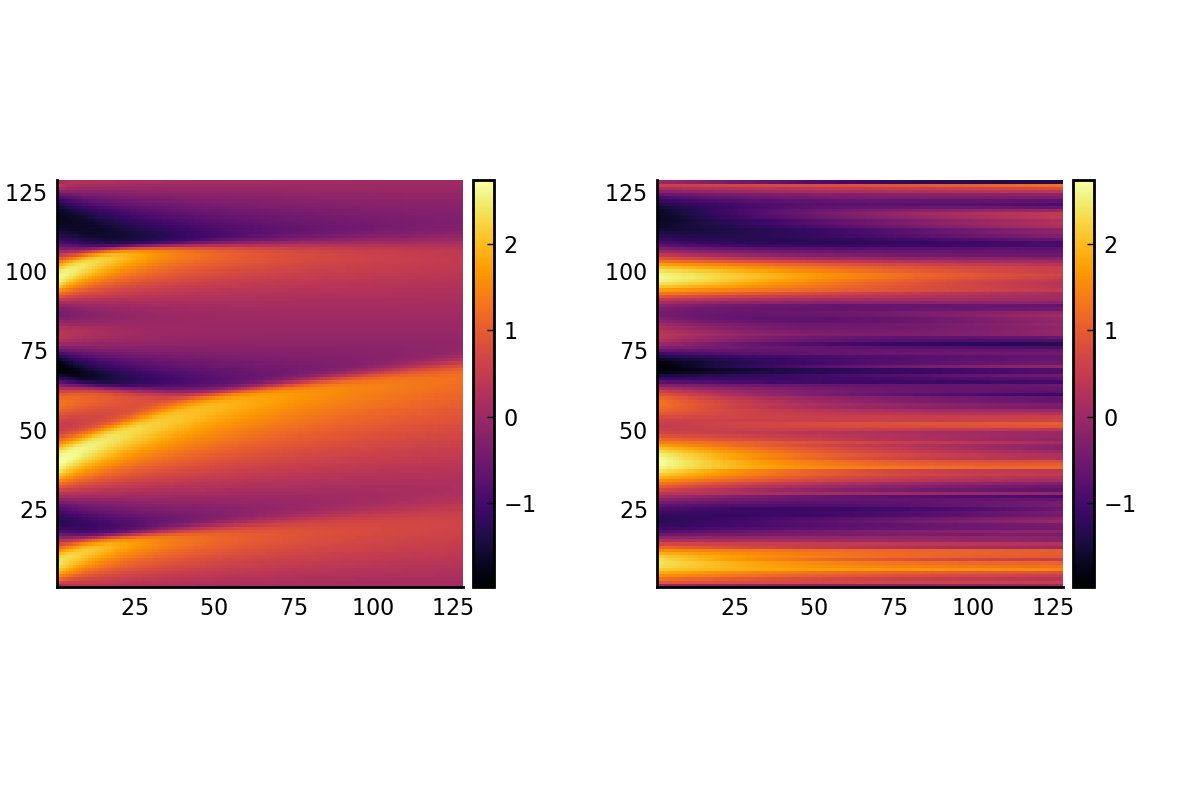

In [79]:
t, u0, u = Generator.get_burgers_batch(t_max, t_min, x_max, x_min, t_n, x_n, nu, 2);
u_pred = Array(S(K, u0, t));
plot(
    GraphicTools.show_state(u, ""),
    GraphicTools.show_state(u_pred, "");
    layout = (1, 2),
)

## Training with solver

In [46]:
function f(u, K, t)
  return K * u
end

function S(net, u0, t)
  tspan = (t[1], t[end])
  prob = ODEProblem(ODEFunction(f), copy(u0), tspan, net)
  sol = solve(prob, Tsit5(), saveat=t, reltol=1e-8, abstol=1e-8)
end

S (generic function with 1 method)

In [48]:
callback(A, loss) = (println(loss); flush(stdout); false)

callback (generic function with 2 methods)

In [ ]:
function burgers_training_2(K, epochs, u0, u_true, tspan)
  
  function loss(K)
    u_pred = Array(S(K, u0, tspan))
    l = Objectives.mseloss(u_pred, u_true)
    return l
  end

  result = DiffEqFlux.sciml_train(loss, K, ADAM(0.01); cb = callback, maxiters = epochs);
  return result
end

In [ ]:
net = zeros(x_n, x_n);
t, u0, u_true = ProcessingTools.process_dataset(high_dataset);
result_2 = burgers_training_2(copy(net), 100, u0, u_true, t);

### Operator reconstructed

In [ ]:
K2 = result_2.u
GraphicTools.show_state(reverse(K2; dims = 1), "")

In [ ]:
# t, u0, u_true = ProcessingTools.process_dataset(dataset);

t, u0, u = Generator.get_burgers_batch(t_max, t_min, x_max, x_min, t_n, x_n, nu, 2);
u_pred_2 = Array(S(K2, u0, t));
display(
    plot(
        GraphicTools.show_state(u, ""),
        GraphicTools.show_state(u_pred_2, ""),
        layout = (1, 2),
    ),
);